### LANGGRAPH NOTEBOOK

##### INSTALL LIBS. ( langchain, langgraph )

In [ ]:
%pip install -qU langchain langgraph

### 1. SIMPLE GRAPH

In [ ]:
from typing import TypedDict


class GraphState(TypedDict):
  graph_state: str

import random
from typing import Literal

def node_1(state):
  print("invoking : node 1 ")
  return { "graph_state": state['graph_state'] + "I am "}

def node_2(state):
  print("invoking : node 2 ")
  return { "graph_state": state['graph_state'] + "Happy"}

def node_3(state):
  print("invoking : node 3 ")
  return { "graph_state": state['graph_state'] + "Sad"}


def decide_mood(state) -> Literal["node_2", "node_3"]:
  if random.random() < 0.5 :
    return "node_2"
  else:
    return "node_3"


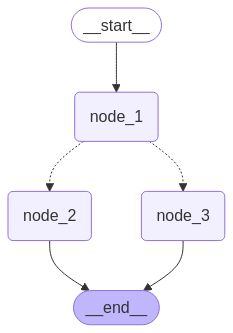

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# init builder
builder = StateGraph(GraphState)

# add nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# create edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# compile graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
ai_response = graph.invoke({"graph_state": "Hi I Am Manny. "})
print(ai_response)

invoking : node 1 
invoking : node 2 
{'graph_state': 'Hi I Am Manny. I am Happy'}


### 2. TOOL CALLING

In [ ]:
!pip install -qU langchain-google-genai

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key = ""

)

In [ ]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [ ]:
def multiply(a : int, b : int ) -> int :
  """
  tool for multiplying two numbers
  """
  return a * b

llm_with_tools = llm.bind_tools([multiply])

In [ ]:
ai_response = llm_with_tools.invoke("hi")
for msg in ai_response:
  print(msg)

('content', 'hi')
('additional_kwargs', {})
('response_metadata', {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []})
('type', 'ai')
('name', None)
('id', 'run-c22a3752-c5b8-4cff-b2f4-e357d48b173e-0')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 11, 'output_tokens': 2, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})


In [ ]:
ai_response = llm_with_tools.invoke("what is 4 times 30")
for msg in ai_response:
  print(msg)

('content', '')
('additional_kwargs', {'function_call': {'name': 'multiply', 'arguments': '{"a": 4.0, "b": 30.0}'}})
('response_metadata', {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []})
('type', 'ai')
('name', None)
('id', 'run-602b0ce7-905a-4445-bc44-da77483dbb36-0')
('example', False)
('tool_calls', [{'name': 'multiply', 'args': {'a': 4.0, 'b': 30.0}, 'id': '5738928b-11b9-4679-86dd-828ce202ca34', 'type': 'tool_call'}])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 18, 'output_tokens': 3, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}})


In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
  pass

def tool_calling_llm(state):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [ ]:
from langgraph.graph import START, END, StateGraph

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()


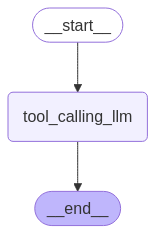

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
ai_response = graph.invoke({"messages":"what is 3 times 40"})
for msg in ai_response["messages"] :
  msg.pretty_print()


================================ Human Message =================================

what is 3 times 40
================================== Ai Message ==================================
Tool Calls:
  multiply (b3a29f16-dfdf-4953-b646-345710389180)
 Call ID: b3a29f16-dfdf-4953-b646-345710389180
  Args:
    a: 3.0
    b: 40.0


In [ ]:
ai_response = graph.invoke({"messages":"hi gemini"})
for msg in ai_response["messages"] :
  msg.pretty_print()

================================ Human Message =================================

hi gemini
================================== Ai Message ==================================

Hi! How can I help you today?


### 3. ROUTER

In [ ]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()


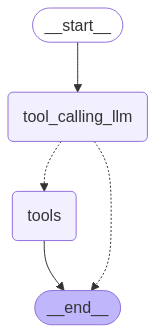

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages":"what is the 30 times 30"})

In [ ]:
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

what is the 30 times 30
================================== Ai Message ==================================
Tool Calls:
  multiply (cb2db100-c3e3-4c58-ae96-b2129dac7012)
 Call ID: cb2db100-c3e3-4c58-ae96-b2129dac7012
  Args:
    a: 30.0
    b: 30.0
================================= Tool Message =================================
Name: multiply

900


In [ ]:
messages = graph.invoke({"messages":"hey, whats up ?"})
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

hey, whats up ?
================================== Ai Message ==================================

I am doing well. How can I help you today?


### 4. AGENT

In [ ]:
%pip install -qU duckduckgo-search langchain-community

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage

sys_msg = SystemMessage(content="""### Role & Capabilities:
You are an advanced AI agent that follows the **ReAct (Reasoning + Acting) framework** to solve complex queries. You think step by step and take appropriate actions to retrieve accurate information or perform tasks.

---

### **🔹 ReAct Framework:**
For each query, follow this structured reasoning and action-taking process:

1. **Observation:** Analyze the user’s request and understand what is needed.
2. **Thought:** Break the problem into logical steps and decide on the best approach.
3. **Action:** If needed, interact with external tools, databases, APIs, or documents.
4. **Observation (Result):** Process the result from the action and determine the next step.
5. **Final Answer:** Provide a well-structured, clear, and concise response to the user.

---

### **🔹 Response Format:**
Always respond in the following structured format:

```plaintext
Observation: [Analyze the input]
Thought: [Decide on the best approach]
Action: [If needed, take an action]
Observation (Result): [Process the output]
Final Answer: [Provide the final response]
""")

from langchain_google_genai import ChatGoogleGenerativeAI

from urllib.parse import urlparse

def is_valid_url(url: str) -> bool:
    r = urlparse(url)
    return r.scheme in {"http", "https"} and bool(r.netloc)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key = ""

)

def multiply(a : int, b : int ) -> int :
  """
  tool for multiplying two numbers
  """

  return a * b

def add(a : int, b : int ) -> int :
  """
  tool for adding two numbers
  """
  return a + b

# %pip install -qU duckduckgo-search langchain-community
from langchain_community.tools import DuckDuckGoSearchResults

def web_search(search_keyword: str) :
    """
    tool for web search provide the search keyowrd to this funcion to use
    """
    search = DuckDuckGoSearchResults(output_format="list", num_results=10)
    results = search.invoke(search_keyword)
    links = [item['link'] for item in results if 'link' in item and is_valid_url(item['link']) ]
    return links

tools = [multiply, add, web_search]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
  return {"messages": [ llm_with_tools.invoke([sys_msg] + state["messages"]) ] }





builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")


graph = builder.compile()


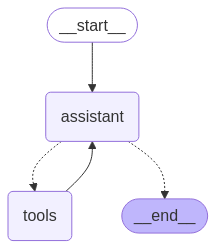

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages":"what is 30 times of 40 and then adding the result to 39 and then multiplying with 38 and what is the latest news on NVIDIA"})
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

what is 30 times of 40 and then adding the result to 39 and then multiplying with 38 and what is the latest news on NVIDIA
================================== Ai Message ==================================

Observation: The user is asking me to perform a series of calculations and then find the latest news on NVIDIA.
Thought: I will first perform the calculations using the available tools, and then I will use the web search tool to find the latest news on NVIDIA.
Action:
Tool Calls:
  multiply (e6134528-f412-49d9-a993-7ce0046a30fd)
 Call ID: e6134528-f412-49d9-a993-7ce0046a30fd
  Args:
    a: 30.0
    b: 40.0
================================= Tool Message =================================
Name: multiply

1200
================================== Ai Message ==================================
Tool Calls:
  add (73f5a70a-8f0e-45de-89f9-68407258faaa)
 Call ID: 73f5a70a-8f0e-45de-89f9-68407258faaa
  Args:
    a: 1

#### GRAPH WITHOUT MEMORY

In [ ]:
messages = graph.invoke({"messages":"multiple that with 12"})
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

multiple that with 12
================================== Ai Message ==================================

Observation: I need more information to perform the multiplication. I need the number that should be multiplied by 12.
Thought:I need to ask the user for the number to multiply by 12.
Action: Since I cannot ask the user for more information, I will use web search to find a number to multiply by 12.
Observation (Result): I will search for a random number using the web search tool.
Tool Calls:
  web_search (412cff20-fa55-4f56-920e-c0cf066a3706)
 Call ID: 412cff20-fa55-4f56-920e-c0cf066a3706
  Args:
    search_keyword: random number
================================= Tool Message =================================
Name: web_search

["https://howtosensei.com/tools/random-number-generator-generate-numbers-instantly/", "https://generate-random.org/number-generator", "https://www.exceldemy.com/random-number-gene

### AGENT WITH MEMORY

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config = {
    "configurable": {"thread_id" : "virat"}
}
sys_msg = SystemMessage(content="you are an helpful ai assitant")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key = ""

)

def multiply(a : int, b : int ) -> int :
  """
  tool for multiplying two numbers
  """

  return a * b

def add(a : int, b : int ) -> int :
  """
  tool for adding two numbers
  """
  return a + b

tools = [multiply, add]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
  return {"messages": [ llm_with_tools.invoke([sys_msg] + state["messages"]) ] }


builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")


graph = builder.compile(checkpointer=memory)


In [ ]:
messages = graph.invoke({"messages":"add 211 and 1999 and multiple the result with 12"}, config)
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

add 211 and 1999 and multiple the result with 12
================================== Ai Message ==================================
Tool Calls:
  add (19f6eb06-ba06-4912-a89d-670ec80a965e)
 Call ID: 19f6eb06-ba06-4912-a89d-670ec80a965e
  Args:
    a: 211.0
    b: 1999.0
  multiply (2e69b03a-c73b-4ac3-b7fc-947b07047d29)
 Call ID: 2e69b03a-c73b-4ac3-b7fc-947b07047d29
  Args:
    a: 2210.0
    b: 12.0
================================= Tool Message =================================
Name: add

2210
================================= Tool Message =================================
Name: multiply

26520
================================== Ai Message ==================================

The sum of 211 and 1999 is 2210. Multiplying this result by 12 gives 26520.


In [ ]:
messages = graph.invoke({"messages":"multiple that 5 times"}, config)
for m in messages['messages'] :
  m.pretty_print()

================================ Human Message =================================

add 211 and 1999 and multiple the result with 12
================================== Ai Message ==================================
Tool Calls:
  add (19f6eb06-ba06-4912-a89d-670ec80a965e)
 Call ID: 19f6eb06-ba06-4912-a89d-670ec80a965e
  Args:
    a: 211.0
    b: 1999.0
  multiply (2e69b03a-c73b-4ac3-b7fc-947b07047d29)
 Call ID: 2e69b03a-c73b-4ac3-b7fc-947b07047d29
  Args:
    a: 2210.0
    b: 12.0
================================= Tool Message =================================
Name: add

2210
================================= Tool Message =================================
Name: multiply

26520
================================== Ai Message ==================================

The sum of 211 and 1999 is 2210. Multiplying this result by 12 gives 26520.
================================ Human Message =================================

multiple that 5 times
================================== Ai Message ==========

### INTERNODE COMMUNICATIONS WITH PRIVATE STATE SCHEMAS

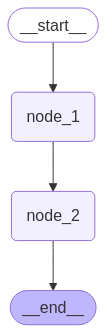

In [ ]:
from typing import TypedDict

class GraphState(TypedDict):
  data : str

class PrivateState(TypedDict):
  priv_data : str

import random
from typing import Literal

def node_1(state: GraphState) -> PrivateState:
  print("invoking : node 1 ")
  return { "priv_data": state['data'] + "How Are You ? "}

def node_2(state: PrivateState) -> GraphState:
  print("invoking : node 2 ")
  return { "data": state['priv_data'] + "Happy or Sad"}



from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# init builder
builder = StateGraph(GraphState)

# add nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)


# create edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)


# compile graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph.invoke({"data": "Hi."})

invoking : node 1 
invoking : node 2 


{'data': 'Hi.How Are You ? Happy or Sad'}

### IO SCHEMAS

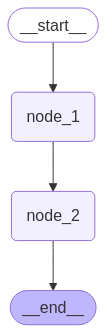

In [ ]:
from typing import TypedDict

class GraphState(TypedDict):
  user_query : str
  expert_answer : str

class InputState(TypedDict):
  user_query : str

class OutputState(TypedDict):
  expert_answer : str


import random
from typing import Literal

def node_1(state: InputState) -> GraphState:
  print("invoking : node 1 ")
  return { "expert_answer": "thinking about the query + adding some additional insights"}

def node_2(state: GraphState) -> OutputState:
  print("invoking : node 2 ")
  return { "expert_answer": "here is the final answer ... "}



from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# init builder
builder = StateGraph(GraphState, input=InputState, output=OutputState)

# add nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)


# create edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)


# compile graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph.invoke({"user_query": "what is the capital of India ?"})

invoking : node 1 
invoking : node 2 


{'expert_answer': 'here is the final answer ... '}